In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from torch.utils.data.dataset import Dataset

In [ ]:
img_size = 64
n_epochs = 50
batch_size = 64
learning_rate = 0.0001

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])

In [ ]:
fmnist = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
data_loader = DataLoader(dataset=fmnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100, 256*7*7, bias = False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        y = self.layer1(x)
        y = y.view((-1,256,7,7))
        y = self.layer2(y)
        return y

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, 2, bias=True),
            nn.LeakyReLU(0.3),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, 5, 2, 2, bias=True),
            nn.LeakyReLU(0.3),
            nn.Dropout2d(0.3),
        )
        self.linear = nn.Linear(128*7*7,1,bias=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):        
        y = self.layer(x)
        y = y.view((-1,128*7*7))
        y = self.linear(y)
        y = self.sigmoid(y)
        return y

In [ ]:
class Labeler(nn.Module):
  def __init__(self):
        super(Labeler, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
  def forward(self,x):
    x = x.view(-1,28*28)
    output = self.layer(x)
    return output


In [ ]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
L = Labeler().to(DEVICE)

In [ ]:
L_opt = torch.optim.Adam(L.parameters(), lr=learning_rate)
crossen = nn.CrossEntropyLoss()
crossen = crossen.to(DEVICE)

In [ ]:
from torch.types import Device
L_loss_hist = []
L_acc_hist = []
for epoch in range(n_epochs):
    L_accs = []
    L_losses = []
    for batch, (real_samples,real_labels) in enumerate(data_loader):
        real_samples = real_samples.float().to(DEVICE)
        real_labels = real_labels.long().to(DEVICE)
        
        L.zero_grad()
        yhat = L(real_samples)
        L_loss = crossen(yhat,real_labels)
        predclass = torch.argmax(yhat,dim=1)
        L_acc = torch.mean((predclass==real_labels).float())
        L_loss.backward()
        L_opt.step()
        L_accs.append(L_acc)
        L_losses.append(L_loss)
    if ((epoch+1)%20==0):
        print(f"Epoch: {epoch+1} Label Accuracy: {torch.mean(torch.FloatTensor(L_accs))} Label Loss: {torch.mean(torch.FloatTensor(L_losses))}")

Epoch: 20 Label Accuracy: 0.9102187752723694 Label Loss: 0.24423833191394806
Epoch: 40 Label Accuracy: 0.9416355490684509 Label Loss: 0.15900221467018127


In [ ]:
target_ones = torch.ones((batch_size, 1), device=DEVICE)
target_zeros = torch.zeros((batch_size, 1), device=DEVICE)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
def generate_samples(G,latent_v):
  with torch.no_grad():
    samples = G(latent_v)
  samples = samples.cpu()
  images = torchvision.utils.make_grid(samples,normalize=True)
  plt.imshow(images.numpy().transpose((1,2,0)))
  plt.show()

Epoch 1 Discriminator Loss: 0.661, Generator Loss: 0.838
Epoch 2 Discriminator Loss: 0.642, Generator Loss: 0.805
Epoch 3 Discriminator Loss: 0.639, Generator Loss: 0.815
Epoch 4 Discriminator Loss: 0.645, Generator Loss: 0.806
Epoch 5 Discriminator Loss: 0.646, Generator Loss: 0.808
Epoch 6 Discriminator Loss: 0.647, Generator Loss: 0.808
Epoch 7 Discriminator Loss: 0.647, Generator Loss: 0.809
Epoch 8 Discriminator Loss: 0.647, Generator Loss: 0.813
Epoch 9 Discriminator Loss: 0.648, Generator Loss: 0.811
Epoch 10 Discriminator Loss: 0.649, Generator Loss: 0.810


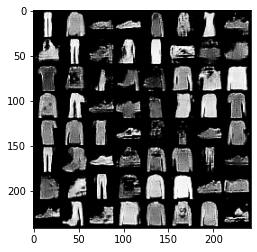

Epoch 11 Discriminator Loss: 0.649, Generator Loss: 0.812
Epoch 12 Discriminator Loss: 0.648, Generator Loss: 0.813
Epoch 13 Discriminator Loss: 0.649, Generator Loss: 0.814
Epoch 14 Discriminator Loss: 0.649, Generator Loss: 0.816
Epoch 15 Discriminator Loss: 0.650, Generator Loss: 0.818
Epoch 16 Discriminator Loss: 0.651, Generator Loss: 0.814
Epoch 17 Discriminator Loss: 0.650, Generator Loss: 0.818
Epoch 18 Discriminator Loss: 0.652, Generator Loss: 0.818
Epoch 19 Discriminator Loss: 0.652, Generator Loss: 0.815
Epoch 20 Discriminator Loss: 0.650, Generator Loss: 0.815
Epoch 21 Discriminator Loss: 0.651, Generator Loss: 0.819
Epoch 22 Discriminator Loss: 0.651, Generator Loss: 0.819
Epoch 23 Discriminator Loss: 0.651, Generator Loss: 0.819
Epoch 24 Discriminator Loss: 0.650, Generator Loss: 0.820
Epoch 25 Discriminator Loss: 0.652, Generator Loss: 0.819
Epoch 26 Discriminator Loss: 0.652, Generator Loss: 0.821
Epoch 27 Discriminator Loss: 0.652, Generator Loss: 0.820
Epoch 28 Discr

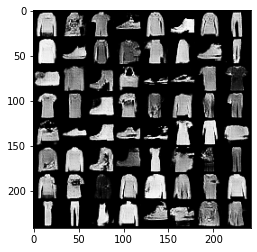

Epoch 31 Discriminator Loss: 0.652, Generator Loss: 0.821
Epoch 32 Discriminator Loss: 0.653, Generator Loss: 0.818
Epoch 33 Discriminator Loss: 0.653, Generator Loss: 0.818
Epoch 34 Discriminator Loss: 0.653, Generator Loss: 0.819
Epoch 35 Discriminator Loss: 0.653, Generator Loss: 0.819
Epoch 36 Discriminator Loss: 0.654, Generator Loss: 0.818
Epoch 37 Discriminator Loss: 0.653, Generator Loss: 0.817
Epoch 38 Discriminator Loss: 0.654, Generator Loss: 0.819
Epoch 39 Discriminator Loss: 0.654, Generator Loss: 0.818
Epoch 40 Discriminator Loss: 0.655, Generator Loss: 0.816
Epoch 41 Discriminator Loss: 0.654, Generator Loss: 0.817
Epoch 42 Discriminator Loss: 0.653, Generator Loss: 0.820
Epoch 43 Discriminator Loss: 0.655, Generator Loss: 0.816
Epoch 44 Discriminator Loss: 0.653, Generator Loss: 0.819
Epoch 45 Discriminator Loss: 0.654, Generator Loss: 0.818
Epoch 46 Discriminator Loss: 0.655, Generator Loss: 0.816
Epoch 47 Discriminator Loss: 0.655, Generator Loss: 0.818
Epoch 48 Discr

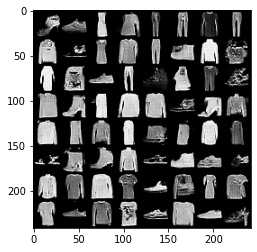

In [ ]:
D_loss_hist = []
G_loss_hist = []
noise = lambda x: torch.randn((x,100), device = DEVICE)
for epoch in range(n_epochs):

  D_losses = []
  G_losses = []
  
  for batch, (images,labels) in enumerate(data_loader):
    real_samples = images.to(DEVICE)
    latent_v = noise(batch_size)
    #Train Discriminator
    D.zero_grad()
    pred_real = D(real_samples)
    loss_real = criterion(pred_real,target_ones)
    with torch.no_grad():
      fake_samples = G(latent_v)
    pred_fake = D(fake_samples)
    loss_fake = criterion(pred_fake,target_zeros)
    loss = (loss_real+loss_fake)/2
    loss.backward()
    D_opt.step()
    D_losses.append(loss)
    
    #Train Generator
    G.zero_grad()
    generated = G(latent_v)
    classes = D(generated)
    gen_loss = criterion(classes, target_ones)
    gen_loss.backward()
    G_opt.step()
    G_losses.append(gen_loss)

    
  print('Epoch {} Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format((epoch + 1),
                                                           torch.mean(torch.FloatTensor(D_losses)),
                                                           torch.mean(torch.FloatTensor(G_losses))))
  if(epoch == 9 or epoch == 29 or epoch == 49):
    generate_samples(G,latent_v)
  D_loss_hist.append(torch.mean(torch.FloatTensor(D_losses)))
  G_loss_hist.append(torch.mean(torch.FloatTensor(G_losses)))

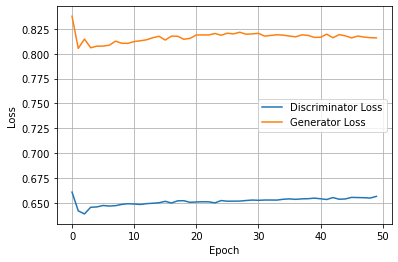

In [ ]:
plt.plot(range(50),D_loss_hist,label='Discriminator Loss')
plt.plot(range(50),G_loss_hist,label='Generator Loss')
plt.legend()
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

As we can see, the two generators are slowly approaching equilibrium somewhere around the 0.75 range. But even after just 50 epochs, the generator is producing elements that are nigh indistinguishable from actual Fashion MNIST images.

tensor([7, 0, 6, 2, 9], device='cuda:0')


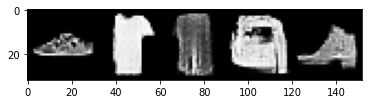

tensor([9, 0, 4, 1, 3], device='cuda:0')


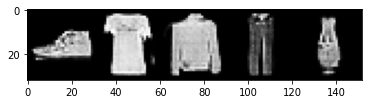

tensor([6, 8, 3, 9, 9], device='cuda:0')


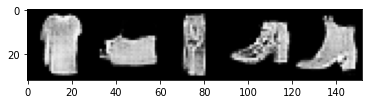

tensor([3, 5, 3, 0, 4], device='cuda:0')


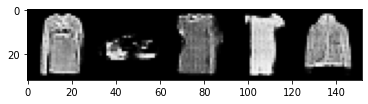

tensor([9, 0, 3, 5, 6], device='cuda:0')


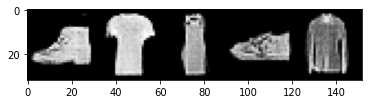

In [ ]:
for i in range(5):
  latent_test = noise(5)
  with torch.no_grad():
      samples = G(latent_test)
      labels = L(samples)
  sample = samples.cpu()
  print(torch.argmax(labels,dim=1))
  images = torchvision.utils.make_grid(sample,normalize=True)
  plt.imshow(images.numpy().transpose((1,2,0)))
  plt.show()

For reference:

    0: T-shirt/top
    1: Trouser
    2: Pullover
    3: Dress
    4: Coat
    5: Sandal
    6: Shirt
    7: Sneaker
    8: Bag
    9: Ankle boot
All of these labels seem very accurate, so this architecture for both the generator and labeler are acceptable